# Feature Selection Methods project - Test Environment
<b>Author: Yuval Uner</b><br/>
<br/>
In this notebook, you can use and experiment with the feature selection tools developed by me for the project.<br/>
You can select a dataset, then try out and compare the different feature selection methods, and see how they affect the model's performance.<br/>

# Importing libraries

Import all of the libraries required for the project, both external libraries as well as the local libraries developed for the project.

## External libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, max_error, log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold, SelectKBest, mutual_info_regression
import seaborn as sns

## Local libraries

In [2]:
from data_pre_processing import PreprocessingPipeline
from filter_methods import WeightedCombination, VarianceInflationFactor
from deep_network_methods import LinearAgent, SequentialAgent
from shap_values_methods import BaseMethod, BranchingVariant, BacktrackingVariant

# Select the dataset, preprocess the data, and choose the model and metrics
Select one of the datasets below, load the data and and preprocess it, then select the relevant model and metrics to use for the task. <br/>
The datasets are divided into 2 categories: linear regression datasets and classification datasets. <br/>
For each category, there are 2 datasets to choose from. <br/>
Please choose only one dataset, and follow the model selection and metric selection steps of the category it belongs to.<br/>
<br/>
All datasets go through the same preprocessing pipeline, which performs the following (in order):
1. Convert categorical features to one-hot encoding
2. Impute missing values by replacing them with the mean of the column
3. Remove features with high collinearity between them. By default, this threshold is set to 0.9.
At the end of the pipeline, the preprocessed data is returned, along with a list of which of the remaining columns are categorical and which are numerical.<br/>

The data can then optionally be normalized using sklearn's StandardScaler.<br/>

## Linear Regression datasets
You may choose of either of the 2 datasets below:
1. Housing dataset. This is the dataset used in class. The same 10 features as used in the introduction lecture are used, as otherwise the dataset has too many features to handle in a reasonable amount of time by the more time consuming methods.
2. WHO life expectancy (https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who). A dataset containing 21 features (20 in this project, as 1 is always dropped) and 2938 rows. It features statistical information about countries and health factors in those countries over several years, with the target variable being the life expectancy in the country.

### Selecting the dataset - please choose one of the following datasets

#### Housing dataset

Load the dataset and select only the relevant columns

In [3]:
data = pd.read_csv('data/data_houses.csv', index_col="Id")
cols = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","FullBath","YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass", "SalePrice"]
data = data[cols]
data

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
Id,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000
...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,2,460,953,2,1999,2000,62.0,60,175000
1457,6,2073,2,500,1542,2,1978,1988,85.0,20,210000
1458,7,2340,1,252,1152,2,1941,2006,66.0,70,266500


Set the target variable

In [4]:
target = 'SalePrice'

For using the sequential agent - select the feature by which to sequence the data. This can be skipped if not using the sequential agent.<br/>
In this case, the feature chosen is YearBuilt, as it may make sense that houses built in different years may have different distributions of features and different sale price distributions.

In [5]:
sequence_by = 'YearBuilt'

Next, preprocess the data using the preprocessing pipeline.

In [6]:
preprocessor = PreprocessingPipeline(data, ['MSSubClass', 'FullBath'], 0.9, target_name='SalePrice')

In [7]:
data, continuous_cols, cat_cols = preprocessor.preprocess()

#### WHO Life Expectancy

Load the dataset

In [331]:
data = pd.read_csv('data/Life Expectancy Data.csv')
# Drop the country column, because it is categorical and with too many unique values.
data = data.drop(columns=['Country'])
data

,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


Set the target variable

In [336]:
target = 'Life expectancy '

For using the sequential agent - select the feature by which to sequence the data. This can be skipped if not using the sequential agent.<br/>
In this case, the feature chosen is Year, as it may make sense for distributions to change over the years, and for worldwide trends to be reflected in the progress of years.

In [337]:
sequence_by = 'Year'

Next, preprocess the data using the preprocessing pipeline.

In [338]:
preprocessor = PreprocessingPipeline(data,
                                     [
                                         'Status'
                                     ],
                                     0.9, target_name=target)

In [339]:
data, continuous_cols, cat_cols = preprocessor.preprocess()

### Model and metric selection
For the linear regression datasets, we use a linear regression model, MSE as the loss function, as well as R2, MAE, Mean Average Percent Error and max error as the evaluation metrics.

In [340]:
model = LinearRegression()
loss_func = mean_squared_error
metrics = [r2_score, mean_absolute_error, mean_absolute_percentage_error, max_error]

## Classification datasets (Logistic Regression)

You may choose of either of the 2 datasets below:
1. IBM HR Analytics Employee Attrition & Performance. A dataset containing 34 features and 1470 rows. It contains information about employees, with the target variable being whether they are experiencing attrition or not.
2. Titanic dataset, imported via the seaborn library. A classic dataset, containing 14 features and 891 rows. It contains information about passengers on the Titanic, with the target variable being whether the passenger survived or not.

### Selecting the dataset - please choose one of the following datasets

#### Telco customer churn dataset

Load the dataset

In [207]:
data = pd.read_csv('data/IBM_hr_attrition_logistic.csv')
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


Set the target variable and remove the id column

In [208]:
target = 'Attrition'

Map boolean "Yes" and "No" features to 1s and 0s.

In [209]:
data[target] = data[target].map({'Yes': 1, 'No': 0})
data['Over18'] = data['Over18'].map({'Y': 1, 'N': 0})
data['OverTime'] = data['OverTime'].map({'Yes': 1, 'No': 0})

For using the sequential agent - select the feature by which to sequence the data. This can be skipped if not using the sequential agent.<br/>
In this case, the feature chosen is tenure, as it may make sense that customers with longer tenure may have a different distribution of features than customers with shorter tenure.

In [210]:
sequence_by = 'YearsInCurrentRole'

Next, preprocess the data using the preprocessing pipeline.

In [211]:
preprocessor = PreprocessingPipeline(data,
                                     cat_cols=[
                                         'BusinessTravel', 'Department', 'Education',
                                         'EducationField', 'EnvironmentSatisfaction', 'Gender',
                                         'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
                                         'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating',
                                         'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
                                     ],
                                     threshold=0.9, target_name=target)
data, continuous_cols, cat_cols = preprocessor.preprocess()

#### Titanic dataset

Load the dataset

In [3]:
data = sns.load_dataset("titanic")
data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


Set the target variable

In [5]:
target = 'survived'

For using the sequential agent - select the feature by which to sequence the data. This can be skipped if not using the sequential agent. <br/>
In this case, the selected feature is age, as it makes sense for the survival rate of passengers of different ages to be different.

In [6]:
sequence_by = 'age'

Next, preprocess the data using the preprocessing pipeline.

In [7]:
preprocessor = PreprocessingPipeline(data, [
    'pclass', 'sex', 'sibsp', 'parch', 'embarked', 
    'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'
], 0.9, target_name=target)

In [8]:
data, continuous_cols, cat_cols = preprocessor.preprocess()

### Model and metric selection
For the classification datasets, we use a logistic regression model, log loss as the loss function, as well as accuracy, precision, recall and F1 score as the evaluation metrics.

In [212]:
model = LogisticRegression()
loss_func = log_loss
metrics = [accuracy_score, precision_score, recall_score, f1_score]

### Normalization - optional
It is highly recommended to use this normalization step for the classification datasets, as sklearn's LogisticRegression model is sensitive to the scale of the features.<br/>
On the other hand, for the linear regression datasets, this step is entirely optional, as the model used (LinearRegression) is not sensitive to the scale of the features.

In [213]:
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

### Split the data

Split the data into training, validation and test sets

In [341]:
X_train, X_test, y_train, y_test = train_test_split(data, data[target], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Feature Selection

## Filter methods

Filter methods are methods that select features based on some statistical measure calculated from the data. They do not involve training a model, and are therefore computationally less expensive than wrapper methods. <br/>
The filter methods implemented in this project are:
1. A weighted sum of correlation and mutual information
2. Variance Inflation Factor (VIF)

Both methods have tunable hyperparameters, which may be adjusted or optimized automatically using the provided methods.<br/>
<br/>
The end of this section contains an evaluation, allowing you to compare the model's performance with and without feature selection using the selected method, as well as compare to sklearn's SelectKBest method.

### Weighted Sum Method

#### Method description

This method computes a weighted sum between the mutual information and the correlation of each feature with the target variable. <br/>
It has a weight parameter $\alpha$, such that the score of each feature is computed as 
$$\alpha \cdot \text{correlation} + (1-\alpha) \cdot \text{mutual information}$$
The value of $\alpha$ is set to 0.5 by default, but can be adjusted by the user.<br/>
<br/>
The algorithm has 2 more hyperparameters - the maximum number of features to select, and a score threshold (features with a score below this threshold are removed).<br/>
Both are set to 0 by default, but at least one of them must be set by the user.

#### Method usage

##### Basic usage

If the target was removed from the data, add it back to the data, as this method requires the target to be present in the data.

In [342]:
if target not in X_train.columns:
    X_train[target] = y_train
    X_val[target] = y_val
    X_test[target] = y_test

Instantiate the WeightedCombination class, and fit it to the data.

In [343]:
feature_selector_weighted = WeightedCombination(correlation_weight=0.5)

In [344]:
feature_selector_weighted.fit(X_train, target_column=target, continuous_cols=continuous_cols,categorical_cols= cat_cols)

Next, you can either run the following cell select features using the current hyperparameters:

In [345]:
X_train_after_selection, selected_features_weighted, feature_scores = feature_selector_weighted.transform(X_train, num_features=5, min_threshold=0.1)

Or you can use the following cell to run the hyperparameter optimization process, which will run a grid search over the hyperparameters and select the best ones.<br/>
By default, this process will not optimize the score threshold, as it is computationally expensive. If you wish to optimize it, set the optimize_threshold parameter to True.

##### Hyperparameter optimization

In [346]:
X_transformed, selected_features_weighted, feature_scores, best_weight, best_loss, best_num_features, best_threshold, history = feature_selector_weighted.auto_optimize(X_train, y_train, X_val, y_val, model=model, loss_function=loss_func)

Weight: 0.0, Num features: 1, Loss: 51.13492570827317
Weight: 0.0, Num features: 2, Loss: 32.603662714464114
Weight: 0.0, Num features: 3, Loss: 29.69805107799603
Weight: 0.0, Num features: 4, Loss: 27.125055533837912
Weight: 0.0, Num features: 5, Loss: 26.58163804356001
Weight: 0.0, Num features: 6, Loss: 21.07782364873613
Weight: 0.0, Num features: 7, Loss: 20.810478516105583
Weight: 0.0, Num features: 8, Loss: 19.737266509770663
Weight: 0.0, Num features: 9, Loss: 19.43065113268913
Weight: 0.0, Num features: 10, Loss: 18.311284052159483
Weight: 0.0, Num features: 11, Loss: 18.161195027335758
Weight: 0.0, Num features: 12, Loss: 18.102310515561307
Weight: 0.0, Num features: 13, Loss: 17.981309655079848
Weight: 0.0, Num features: 14, Loss: 18.088588413446033
Weight: 0.0, Num features: 15, Loss: 18.24679282059312
Weight: 0.0, Num features: 16, Loss: 18.116982397047362
Weight: 0.0, Num features: 17, Loss: 18.06736965973335
Weight: 0.0, Num features: 18, Loss: 18.065102836566012
Weight: 

If you ran the optimization process, you also get a history of the optimization process, which you can plot using the following cell.<br/>
This gives a nice visualization of the loss as a function of the hyperparameters, showing if and how the model performs with less features, or with a different weight between correlation and mutual information.

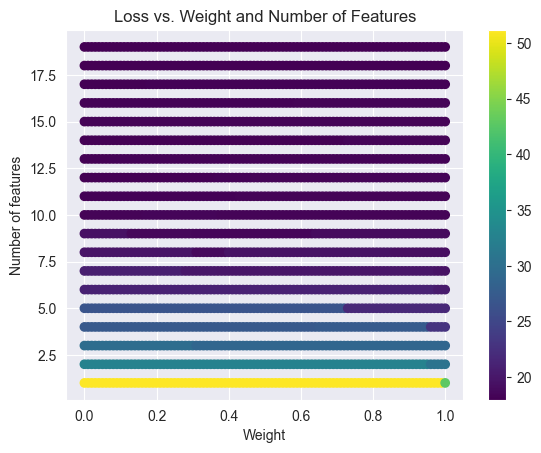

In [347]:
weights, num_features = np.meshgrid(history.columns, history.index)
plt.scatter(weights, num_features, c=history.values, cmap='viridis')
plt.xlabel('Weight')
plt.ylabel('Number of features')
plt.title('Loss vs. Weight and Number of Features')
plt.colorbar()
plt.show()

##### Features and training a model

Examine the selected features

In [348]:
print(f'Number of features selected: {len(selected_features_weighted)}')
print(f'Selected features: {selected_features_weighted}')

Number of features selected: 13
Selected features: Index(['Adult Mortality', 'Income composition of resources',
       ' thinness  1-19 years', 'Schooling', ' BMI ', ' HIV/AIDS',
       'under-five deaths ', 'GDP', 'Alcohol', 'Polio', 'Diphtheria ',
       'percentage expenditure', 'Total expenditure'],
      dtype='object')


Train a model using the selected features.

In [349]:
# Reset the model, to make sure it is not influenced by the previous training
model = model.__class__()
model.fit(X_train[selected_features_weighted], y_train)
y_pred = model.predict(X_test[selected_features_weighted])
loss = loss_func(y_test, y_pred)
with_feature_selection_weighted = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_weighted[loss_func.__name__] = loss
with_feature_selection_weighted['Number of features'] = len(selected_features_weighted)
print(f"Metrics with feature selection: {with_feature_selection_weighted}")

Metrics with feature selection: {'r2_score': 0.8187989827447886, 'mean_absolute_error': 2.912960562253699, 'mean_absolute_percentage_error': 0.045422386877334464, 'max_error': 15.386731871606798, 'mean_squared_error': 16.619741224811516, 'Number of features': 13}


### Variance Inflation Factor

#### Method description

Variance Inflation Factor (VIF) is a measure of multicollinearity among the features. It measures how much the variance of the estimated coefficients of a feature is increased due to multicollinearity. <br/>
Generally, a VIF of 1 indicates no multicollinearity, while a VIF of above 5-10 indicates high multicollinearity, and the feature should be removed. <br/>
This method computes the VIF of each feature, and removes all features with a VIF above or below a certain threshold (up to the user's choice). The threshold is set to 5 by default, but can be adjusted by the user or optimized automatically.<br/>
The method also has a hyperparameter to select the maximum number of features to keep, which is set to 0 by default, meaning all features with a VIF below the threshold will be kept.<br/>
<br/>
The user can choose whether the comparison direction is 'above' or 'below' the threshold, meaning whether to remove features with a VIF above or below the threshold. The default is 'above'.<br/>
This is done because depending on the dataset, a high VIF may indicate that the feature contains important information, despite the multicollinearity, and from empirical observations, it seems that some datasets perform much better when removing features with a VIF below the threshold instead of above it.

#### Method usage

##### Basic usage

First, remove the target feature from the data, if it was not already removed.

In [350]:
if target in X_train.columns:
    X_train = X_train.drop(columns=[target])
    X_val = X_val.drop(columns=[target])
    X_test = X_test.drop(columns=[target])

Instantiate the VarianceInflationFactor class, and fit it to the data.

In [351]:
feature_selector_vif = VarianceInflationFactor()

In [352]:
feature_selector_vif.fit(X_train)

Next, you can either run the following cell select features using the current hyperparameters:

In [353]:
selected_features_vif = feature_selector_vif.predict(X_train, threshold=5, num_features=0, less_than_threshold_comparison=True)

##### Hyperparameter optimization

Or you can use the following cell to run the hyperparameter optimization process, which will run a grid search over the hyperparameters and select the best ones.<br/>

In [354]:
selected_features_vif, best_loss, best_threshold, best_num_features, best_comparison_direction,history_less_than_comparisons, history_greater_than_comparisons = feature_selector_vif.auto_optimize(X_train, y_train, X_val, y_val, model=model, loss_function=loss_func)

Threshold: 0.5, Num features: 1, Less than comparison: True, Loss: inf
Threshold: 0.5, Num features: 1, Less than comparison: False, Loss: 87.31119034419937
Threshold: 0.5, Num features: 2, Less than comparison: True, Loss: inf
Threshold: 0.5, Num features: 2, Less than comparison: False, Loss: 43.08303121863016
Threshold: 0.5, Num features: 3, Less than comparison: True, Loss: inf
Threshold: 0.5, Num features: 3, Less than comparison: False, Loss: 40.11204844455025
Threshold: 0.5, Num features: 4, Less than comparison: True, Loss: inf
Threshold: 0.5, Num features: 4, Less than comparison: False, Loss: 39.41681703001003
Threshold: 0.5, Num features: 5, Less than comparison: True, Loss: inf
Threshold: 0.5, Num features: 5, Less than comparison: False, Loss: 38.9413958904354
Threshold: 0.5, Num features: 6, Less than comparison: True, Loss: inf
Threshold: 0.5, Num features: 6, Less than comparison: False, Loss: 39.31163289174244
Threshold: 0.5, Num features: 7, Less than comparison: True

If you ran the optimization process, you also get a history of the optimization process, which you can plot using the following cell.<br/>
This gives a nice visualization of the loss as a function of the hyperparameters, showing if and how the model performs with less features, with a different threshold, or with a different comparison direction.

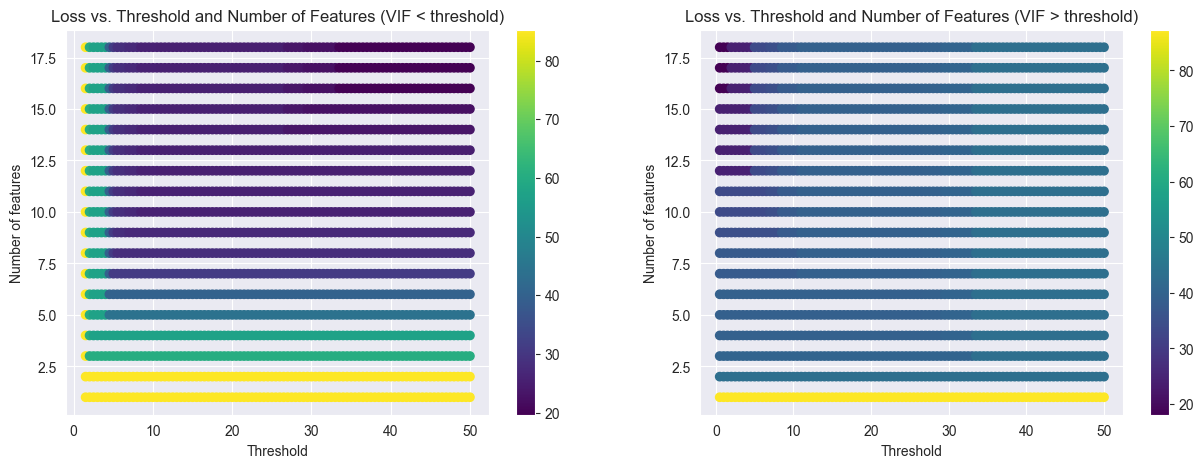

In [355]:
thresholds, num_features = np.meshgrid(history_less_than_comparisons.columns, history_less_than_comparisons.index)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Number of features')
ax[0].set_title('Loss vs. Threshold and Number of Features (VIF < threshold)')
fig.colorbar(ax[0].scatter(thresholds, num_features, c=history_less_than_comparisons.values, cmap='viridis'))

thresholds, num_features = np.meshgrid(history_greater_than_comparisons.columns, history_greater_than_comparisons.index)
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Number of features')
ax[1].set_title('Loss vs. Threshold and Number of Features (VIF > threshold)')
fig.colorbar(ax[1].scatter(thresholds, num_features, c=history_greater_than_comparisons.values, cmap='viridis'))
plt.show()

##### Features and training a model

Examine the selected features

In [356]:
print(f'Number of features selected: {len(selected_features_vif)}')
print(f'Selected features: {selected_features_vif}')

Number of features selected: 18
Selected features: Index(['Year', 'Schooling', 'Income composition of resources', 'Diphtheria ',
       'Polio', 'Hepatitis B', 'Status_Developing', 'Total expenditure',
       ' BMI ', 'GDP', 'percentage expenditure', 'Adult Mortality',
       ' thinness  1-19 years', 'Alcohol', 'under-five deaths ', ' HIV/AIDS',
       'Population', 'Measles '],
      dtype='object')


Train a model using the selected features.

In [357]:
# Reset the model, to make sure it is not influenced by the previous training
model = model.__class__()
model.fit(X_train[selected_features_vif], y_train)
y_pred = model.predict(X_test[selected_features_vif])
loss = loss_func(y_test, y_pred)
with_feature_selection_vif = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_vif[loss_func.__name__] = loss
with_feature_selection_vif['Number of features'] = len(selected_features_vif)
print(f"Metrics with feature selection: {with_feature_selection_vif}")

Metrics with feature selection: {'r2_score': 0.8178949380246738, 'mean_absolute_error': 2.933860235130602, 'mean_absolute_percentage_error': 0.0456311370011023, 'max_error': 14.948110885354673, 'mean_squared_error': 16.702660126325195, 'Number of features': 18}


### Method evaluation

#### Other methods used for comparison

Next, to evaluate the method, we first need to drop the target feature from the data.

In [358]:
if target in X_train.columns:
    X_train = X_train.drop(columns=[target])
    X_val = X_val.drop(columns=[target])
    X_test = X_test.drop(columns=[target])

Compare to a baseline model, which uses all of the features.

In [359]:
model = model.__class__()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
loss = loss_func(y_test, y_pred)
without_feature_selection = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
without_feature_selection[loss_func.__name__] = loss
without_feature_selection['Number of features'] = len(X_train.columns)
print(f"Metrics without feature selection: {without_feature_selection}")

Metrics without feature selection: {'r2_score': 0.8178949380632676, 'mean_absolute_error': 2.9338602344421782, 'mean_absolute_percentage_error': 0.04563113699022702, 'max_error': 14.948110886667514, 'mean_squared_error': 16.702660122785378, 'Number of features': 18}


Compare to sklearn's VarianceThreshold method (sklearn's model agnostic filter method), with the threshold set to 0.8, same as in the example on the documentation.

In [360]:
selector = VarianceThreshold(threshold=0.8)
selector.fit(X_train, y_train)
selected_features_sklearn = X_train.columns[selector.get_support()]
print(f'Selected features using VarianceThreshold: {selected_features_sklearn}')

Selected features using VarianceThreshold: Index(['Year', 'Adult Mortality', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
       'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', 'Schooling'],
      dtype='object')


In [361]:
model = model.__class__()
model.fit(X_train[selected_features_sklearn], y_train)
y_pred = model.predict(X_test[selected_features_sklearn])
loss = loss_func(y_test, y_pred)
with_feature_selection_sklearn_var_thresh = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_sklearn_var_thresh[loss_func.__name__] = loss
with_feature_selection_sklearn_var_thresh['Number of features'] = len(selected_features_sklearn)
print(f"Metrics with feature selection using VarianceThreshold: {with_feature_selection_sklearn_var_thresh}")

Metrics with feature selection using VarianceThreshold: {'r2_score': 0.8195833509834556, 'mean_absolute_error': 2.9499851946920557, 'mean_absolute_percentage_error': 0.04604211876577469, 'max_error': 14.32120022841196, 'mean_squared_error': 16.54779903955741, 'Number of features': 16}


Finally, compare to sk_learn's SelectKBest as well, using mutual_info_regression as the score function. This method is not model agnostic, but it is still a filter method and can be used for comparison.

In [362]:
selector = SelectKBest(score_func=mutual_info_regression)
selector.fit(X_train, y_train)
selected_features_sklearn = X_train.columns[selector.get_support()]
print(f'Selected features using SelectKBest: {selected_features_sklearn}')

Selected features using SelectKBest: Index(['Adult Mortality', 'Alcohol', ' BMI ', 'under-five deaths ', 'Polio',
       ' HIV/AIDS', 'GDP', ' thinness  1-19 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [363]:
model = model.__class__()
model.fit(X_train[selected_features_sklearn], y_train)
y_pred = model.predict(X_test[selected_features_sklearn])
loss = loss_func(y_test, y_pred)
with_feature_selection_sklearn_k_best = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_sklearn_k_best[loss_func.__name__] = loss
with_feature_selection_sklearn_k_best['Number of features'] = len(selected_features_sklearn)
print(f"Metrics with feature selection using SelectKBest: {with_feature_selection_sklearn_k_best}")

Metrics with feature selection using SelectKBest: {'r2_score': 0.8133234374624707, 'mean_absolute_error': 2.963200502771747, 'mean_absolute_percentage_error': 0.046342461948944445, 'max_error': 16.04138025495768, 'mean_squared_error': 17.121957752264496, 'Number of features': 10}


#### Results

If you only ran the cells for the weighted sum method, run this cell to format the results into a table

In [364]:
results = pd.DataFrame([with_feature_selection_weighted, without_feature_selection, with_feature_selection_sklearn_var_thresh, with_feature_selection_sklearn_k_best], index=[f'Feature selection: {feature_selector_weighted.__name__}', 'Without feature selection', 'sklearn Variance Threshold', 'sklearn SelectKBest'])
results

,r2_score,mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error,Number of features
Feature selection: WeightedCombination,0.818799,2.912961,0.045422,15.386732,16.619741,13
Without feature selection,0.817895,2.933860,0.045631,14.948111,16.702660,18
sklearn Variance Threshold,0.819583,2.949985,0.046042,14.321200,16.547799,16
sklearn SelectKBest,0.813323,2.963201,0.046342,16.041380,17.121958,10


If you only ran the cells for the VIF method, run this cell to format the results into a table

In [365]:
results = pd.DataFrame([with_feature_selection_vif, without_feature_selection, with_feature_selection_sklearn_var_thresh, with_feature_selection_sklearn_k_best], index=[f'Feature selection: {feature_selector_vif.__class__.__name__}', 'Without feature selection', 'sklearn Variance Threshold', 'sklearn SelectKBest'])
results

,r2_score,mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error,Number of features
Feature selection: VarianceInflationFactor,0.817895,2.933860,0.045631,14.948111,16.702660,18
Without feature selection,0.817895,2.933860,0.045631,14.948111,16.702660,18
sklearn Variance Threshold,0.819583,2.949985,0.046042,14.321200,16.547799,16
sklearn SelectKBest,0.813323,2.963201,0.046342,16.041380,17.121958,10


If you ran both methods, run this cell to format the results into a table

In [366]:
results = pd.DataFrame([with_feature_selection_weighted, with_feature_selection_vif, without_feature_selection, with_feature_selection_sklearn_var_thresh, with_feature_selection_sklearn_k_best], index=[f'Feature selection: {feature_selector_weighted.__class__.__name__}', f'Feature selection: {feature_selector_vif.__class__.__name__}', 'Without feature selection', 'sklearn Variance Threshold', 'sklearn SelectKBest'])
results

,r2_score,mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error,Number of features
Feature selection: WeightedCombination,0.818799,2.912961,0.045422,15.386732,16.619741,13
Feature selection: VarianceInflationFactor,0.817895,2.933860,0.045631,14.948111,16.702660,18
Without feature selection,0.817895,2.933860,0.045631,14.948111,16.702660,18
sklearn Variance Threshold,0.819583,2.949985,0.046042,14.321200,16.547799,16
sklearn SelectKBest,0.813323,2.963201,0.046342,16.041380,17.121958,10


## Wrapper methods using deep reinforcement learning
Wrapper methods are methods that select features by training a model, and using the model's performance as a measure of the feature's importance, treating the model as a black box. <br/>
<br/>
Feature selection can be described as a prediction problem, where a model needs to predict which subset of features will lead to the best performance. <br/>
To do this in an interpretable way using neural networks, there needs to be a "disconnect" between the feature selection model and the model that uses the selected features, thus making it impossible to directly compute gradients for the feature selection model. <br/>
Thus, reinforcement learning was used.<br/>
<br/>
There are 2 methods implemented in this project:
1. LinearAgent
2. SequentialAgent

In the case of these algorithms, the prediction model is used to compute the reward for the feature selection model, and the feature selection model is trained using reinforcement learning. <br/>
<br/>
All methods were implemented using the StableBaselines3 library, which is a PyTorch-based library for reinforcement learning.

### LinearAgent

#### Method description

LinearAgent uses a linear model as a feature extractor for the feature selection task. <br/>
The agent is trained via either the A2C or PPO policies.<br/>
The environment's action space is a binary vector, where each element corresponds to a feature, and the agent can choose to select or not select each feature.<br/>
The environment's observation space is a batch of data.<br/>
Each step the agent predicts features by a batch of data, and the environment returns the reward, which is the performance of the downstream model on the selected features. An episode is a full pass over the data (one epoch).<br/>
<br/>
It uses a default network architecture, where the input layer is the number of features, and each subsequent layer has half the number of neurons as the previous layer, until reaching the size of the output layer (the number of features). Additionally, the network uses ReLU activations and has a layer normalization layer after every 2 layers.<br/>
<br/>
the user can customize Both the network and the environment, by passing the relevant classes to the agent's constructor.<br/>

#### Method usage

##### Training the agent

First, remove the target feature from the data, if it was not already removed.

In [367]:
if target in X_train.columns:
    X_train = X_train.drop(columns=[target])
    X_val = X_val.drop(columns=[target])
    X_test = X_test.drop(columns=[target])

Set the batch size for the agent

In [384]:
batch_size = 256

Instantiate the LinearAgent class

In [385]:
lin_agent = LinearAgent(X_train, y_train, LinearRegression(), mean_squared_error, batch_size=batch_size, agent_type='A2C',save_path="models/linear_agent", eval_freq=500)
print(lin_agent.agent.policy)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
ActorCriticPolicy(
  (features_extractor): DefaultFullyConnectedNetwork()
  (pi_features_extractor): DefaultFullyConnectedNetwork()
  (vf_features_extractor): DefaultFullyConnectedNetwork()
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=18, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


Train the agent over a certain number of steps.
Note: this may take a long time.

In [386]:
lin_agent.learn(num_steps=4000)

C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=-98.13 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -98.1    |
| time/                 |          |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -12.5    |
|    explained_variance | 5e-05    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -901     |
|    value_loss         | 7.04e+03 |
------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -140     |
| time/              |          |
|    fps             | 18       |
|    iterations      | 100      |
|    time_elapsed    | 27       |
|    total_timesteps | 500      |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-98.36 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -98.4    |
| time/                 |          |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -12.4    |
|    explained_variance | 2.23e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -841     |
|    value_loss         | 5.63e+03 |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -137     |
| time/              |          |
|    fps             | 22       |
|    iterations      | 200      |
|    time_elapsed    | 44       |
|    total_timesteps | 1000     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1500, episode_reward=-89.22 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -89.2    |
| time/                 |          |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -12.1    |
|    explained_variance | 5.38e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | -771     |
|    value_loss         | 5.1e+03  |
------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -128     |
| time/              |          |
|    fps             | 23       |
|    iterations      | 300      |
|    time_elapsed    | 62       |
|    total_timesteps | 1500     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000, episode_reward=-88.97 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -89      |
| time/                 |          |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -12      |
|    explained_variance | 2.38e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss        | -871     |
|    value_loss         | 6.35e+03 |
------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -119     |
| time/              |          |
|    fps             | 25       |
|    iterations      | 400      |
|    time_elapsed    | 79       |
|    total_timesteps | 2000     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2500, episode_reward=-87.83 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -87.8    |
| time/                 |          |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -11.3    |
|    explained_variance | 2.46e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 499      |
|    policy_loss        | -445     |
|    value_loss         | 1.98e+03 |
------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -118     |
| time/              |          |
|    fps             | 25       |
|    iterations      | 500      |
|    time_elapsed    | 97       |
|    total_timesteps | 2500     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3000, episode_reward=-89.19 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -89.2    |
| time/                 |          |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -10.9    |
|    explained_variance | 2.15e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 599      |
|    policy_loss        | -335     |
|    value_loss         | 1.77e+03 |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -108     |
| time/              |          |
|    fps             | 26       |
|    iterations      | 600      |
|    time_elapsed    | 114      |
|    total_timesteps | 3000     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3500, episode_reward=-87.83 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -87.8    |
| time/                 |          |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -10.2    |
|    explained_variance | 2.2e-05  |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | -94.6    |
|    value_loss         | 841      |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -101     |
| time/              |          |
|    fps             | 26       |
|    iterations      | 700      |
|    time_elapsed    | 132      |
|    total_timesteps | 3500     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=-88.98 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 5        |
|    mean_reward        | -89      |
| time/                 |          |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -10      |
|    explained_variance | 2.04e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | -113     |
|    value_loss         | 773      |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -99.6    |
| time/              |          |
|    fps             | 26       |
|    iterations      | 800      |
|    time_elapsed    | 150      |
|    total_timesteps | 4000     |
---------------------------------


Optionally, save the model. This is useful if you want to continue training later, or if you want to load the model for evaluation.<br/>
There is a load method, which can be used to load the model.

In [372]:
lin_agent.save(model_name="end_of_training")

##### Predicting features and training a model

Predict the features on a batch of data, sampled from the validation data

In [387]:
X_val_sample = X_val.sample(batch_size, replace=True)

Setting deterministic to True will make the agent always select the same features for the same data, while setting it to False will allow the agent to select a different (potentially similar) set of features for the same data, potentially improving the model's performance.


In [388]:
action = lin_agent.predict(X_val_sample, deterministic=True)
selected_features = X_train.columns[action == 1]
print(f'Number of selected features: {len(selected_features)}, Selected features: {selected_features}')

Number of selected features: 14, Selected features: Index(['Year', 'Adult Mortality', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'Population', ' thinness  1-19 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


Run the cell below to train a model using the selected features.<br/>
The evaluation when compared to other methods can be done further below, beneath the sequential agent section.

In [389]:
# Reset the model, to make sure it is not influenced by the previous training
model = model.__class__()
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
loss = loss_func(y_test, y_pred)
with_feature_selection = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection[loss_func.__name__] = loss
with_feature_selection['Number of features'] = len(selected_features)
print(f"Metrics with feature selection: {with_feature_selection}")

Metrics with feature selection: {'r2_score': 0.8052259735644206, 'mean_absolute_error': 2.9932807988040397, 'mean_absolute_percentage_error': 0.04686945073478172, 'max_error': 16.622376681908527, 'mean_squared_error': 17.86465642251148, 'Number of features': 14}


### SequentialAgent

#### Method description

SequentialAgent treats the data as a collection of sequences, where each sequence is a subset of the data, sorted and separated by a certain feature. <br/>
It can use either a linear neural network or a bi-directional self-attentive LSTM network as the feature extractor for the feature selection task with either the A2C or PPO policies, or use the RecurrentPPO policy with a linear feature extractor and a LSTM as the policy network.<br/>
The default uses the A2C policy with a LSTM network as the feature extractor.<br/>
This method can select different features for different sequences (although it may also select the same features for all sequences), which can then be used for training several models, each for a different sequence.<br/>
For example, in the housing dataset, a sequence could be all houses built between 1850 and 1900, and another sequence could be all houses built between 1900 and 1950.<br/>

#### Method usage

##### Training the agent

First, remove the target feature from the data, if it was not already removed.

In [390]:
if target in X_train.columns:
    X_train = X_train.drop(columns=[target])
    X_val = X_val.drop(columns=[target])
    X_test = X_test.drop(columns=[target])

Instantiate the SequentialAgent class

In [391]:
sequential_agent = SequentialAgent(
    X_train=X_train,
    y_train=y_train,
    col=sequence_by,
    downstream_model=model,
    loss_function=loss_func,
    agent_type='A2C',
    network_type='recurrent',
    save_path='models/sequential_agent',
    eval_freq=500,
    lstm_hidden_layer_size=64,
    lstm_num_layers=2,
    clustering_method='MeanShift'
)
print(sequential_agent.agent.policy)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
ActorCriticPolicy(
  (features_extractor): DefaultSequenceModelingNetwork(
    (lstm): LSTM(18, 64, num_layers=2, batch_first=True, bidirectional=True)
    (downsample_layer): Linear(in_features=128, out_features=18, bias=True)
    (attention_weights): Linear(in_features=18, out_features=1, bias=True)
  )
  (pi_features_extractor): DefaultSequenceModelingNetwork(
    (lstm): LSTM(18, 64, num_layers=2, batch_first=True, bidirectional=True)
    (downsample_layer): Linear(in_features=128, out_features=18, bias=True)
    (attention_weights): Linear(in_features=18, out_features=1, bias=True)
  )
  (vf_features_extractor): DefaultSequenceModelingNetwork(
    (lstm): LSTM(18, 64, num_layers=2, batch_first=True, bidirectional=True)
    (downsample_layer): Linear(in_features=128, out_features=18, bias=True)
    (attention_weights): Linear(in_features=18, out_features=1, bias=True)
  )
  (mlp_extractor)

It is possible to examine the sequences the model will use for training by using the sequencer object, which can be obtained by calling the get_sequencer method on the agent.

In [392]:
sequencer = sequential_agent.get_sequencer()
train_sequences, train_targets = sequencer.sequence_by_ranges(X_train, y_train)
print(f'Number of sequences: {len(train_sequences)}')
print(f'Sequence lengths: {[len(sequence) for sequence in train_sequences]}')

Number of sequences: 4
Sequence lengths: [840, 562, 422, 423]


Train the agent for a specified number of steps.
Note: this may take a long time.

In [393]:
sequential_agent.learn(num_steps=2000)

C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=-59.08 +/- 0.00
Episode length: 4.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 4         |
|    mean_reward        | -59.1     |
| time/                 |           |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -11.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -440      |
|    value_loss         | 2.27e+03  |
-------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -92.3    |
| time/              |          |
|    fps             | 3        |
|    iterations      | 100      |
|    time_elapsed    | 139      |
|    total_timesteps | 500      |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=-63.79 +/- 0.00
Episode length: 4.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 4         |
|    mean_reward        | -63.8     |
| time/                 |           |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -10.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -281      |
|    value_loss         | 1.34e+03  |
-------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -87.9    |
| time/              |          |
|    fps             | 3        |
|    iterations      | 200      |
|    time_elapsed    | 300      |
|    total_timesteps | 1000     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1500, episode_reward=-59.39 +/- 0.00
Episode length: 4.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 4        |
|    mean_reward        | -59.4    |
| time/                 |          |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -9.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | -240     |
|    value_loss         | 1.06e+03 |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -77      |
| time/              |          |
|    fps             | 3        |
|    iterations      | 300      |
|    time_elapsed    | 453      |
|    total_timesteps | 1500     |
---------------------------------


C:\Users\Yuval\PycharmProjects\TDS_Final_Project\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000, episode_reward=-59.20 +/- 0.00
Episode length: 4.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 4        |
|    mean_reward        | -59.2    |
| time/                 |          |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -9.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss        | -151     |
|    value_loss         | 914      |
------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -72.4    |
| time/              |          |
|    fps             | 3        |
|    iterations      | 400      |
|    time_elapsed    | 570      |
|    total_timesteps | 2000     |
---------------------------------


Optionally - save the model

In [ ]:
sequential_agent.save(model_name="end_of_training")

##### Predicting features and training models

Get the agent's predictions on the validation set, then train models on the predicted feature set.

In [394]:
predictions = sequential_agent.predict(X_train, deterministic=True)
for prediction in predictions:
    print(X_train.columns[prediction == 1])

Index(['Year', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'Measles ',
       ' BMI ', 'under-five deaths ', 'Polio', 'Diphtheria ', ' HIV/AIDS',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')
Index(['Year', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'Measles ',
       ' BMI ', 'under-five deaths ', 'Polio', 'Diphtheria ', ' HIV/AIDS',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')
Index(['Year', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'Measles ',
       ' BMI ', 'under-five deaths ', 'Polio', 'Diphtheria ', ' HIV/AIDS',
       'GDP', 'Population', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')
Index(['Year', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'Measles ',
       ' BMI ', 'under-five deaths ', 'Polio', 'Diphtheria ', ' HIV/AIDS',
       'GDP', 'Population', 'In

Initialize a list of models, then sequence the training and test data by the ranges of sequences found on the training set.

In [395]:
models_with_sequencing_and_feature_selection = []
metrics_with_sequencing_and_feature_selection = []
sequencer = sequential_agent.get_sequencer()
train_sequences, train_targets = sequencer.sequence_by_ranges(X_train, y_train)
test_sequences, test_targets = sequencer.sequence_by_ranges(X_test, y_test)

In [396]:
for i in range(len(train_sequences)):
    X_train_sequence = train_sequences[i]
    # Choose the features selected by the agent
    X_train_sequence = X_train_sequence[X_train_sequence.columns[predictions[i] == 1]]
    y_train_sequence = train_targets[i]
    X_test_sequence = test_sequences[i]
    X_test_sequence = X_test_sequence[X_test_sequence.columns[predictions[i] == 1]]
    y_test_sequence = test_targets[i]
    
    # If any sequence is empty, we skip training a model on it. An empty sequence indicates that any samples in the sequence range are outliers.
    # This is an edge case, which should normally not happen, but can happen if the dataset has either a very small number of samples or a small number of outliers that could not be grouped together.
    if X_train_sequence.shape[0] == 0 or X_test_sequence.shape[0] == 0:
        continue
    
    model = model.__class__()
    model.fit(X_train_sequence, y_train_sequence)
    y_pred = model.predict(X_test_sequence)
    
    loss = loss_func(y_test_sequence, y_pred)
    sequence_metrics = {metric.__name__: metric(y_test_sequence, y_pred) for metric in metrics}
    sequence_metrics[loss_func.__name__] = loss
    sequence_metrics['Number of features'] = len(X_train_sequence.columns)
    
    metrics_with_sequencing_and_feature_selection.append(sequence_metrics)
    models_with_sequencing_and_feature_selection.append(model)

In [397]:
for metric_collection in metrics_with_sequencing_and_feature_selection:
    print(metric_collection)

{'r2_score': 0.8141988098298223, 'mean_absolute_error': 3.341740007530315, 'mean_absolute_percentage_error': 0.05295133914515717, 'max_error': 13.419964273644808, 'mean_squared_error': 19.270130035413352, 'Number of features': 15}
{'r2_score': 0.7588022516962865, 'mean_absolute_error': 3.2995193703131496, 'mean_absolute_percentage_error': 0.04891814385090099, 'max_error': 9.672149516982827, 'mean_squared_error': 19.099539130991086, 'Number of features': 15}
{'r2_score': 0.8584747670842876, 'mean_absolute_error': 2.642077747444735, 'mean_absolute_percentage_error': 0.040843776515865016, 'max_error': 9.280224302626394, 'mean_squared_error': 12.009127470441427, 'Number of features': 15}
{'r2_score': 0.8522877648524138, 'mean_absolute_error': 2.2821761587198335, 'mean_absolute_percentage_error': 0.0352065236107917, 'max_error': 10.161782924054663, 'mean_squared_error': 10.29911296237694, 'Number of features': 15}


Compute and print average, max and min metrics along all of the models

In [398]:
avg_metrics_with_sequencing_with_feature_selection = {metric: np.mean([model_metrics[metric] for model_metrics in metrics_with_sequencing_and_feature_selection]) for metric in
                   metrics_with_sequencing_and_feature_selection[0].keys()}
max_metrics_with_sequencing_with_feature_selection = {metric: np.max([model_metrics[metric] for model_metrics in metrics_with_sequencing_and_feature_selection]) for metric in
                   metrics_with_sequencing_and_feature_selection[0].keys()}
min_metrics_with_sequencing_with_feature_selection = {metric: np.min([model_metrics[metric] for model_metrics in metrics_with_sequencing_and_feature_selection]) for metric in
                   metrics_with_sequencing_and_feature_selection[0].keys()}
print(f"Average metrics: {avg_metrics_with_sequencing_with_feature_selection}")
print(f"Max metrics: {max_metrics_with_sequencing_with_feature_selection}")
print(f"Min metrics: {min_metrics_with_sequencing_with_feature_selection}")

Average metrics: {'r2_score': 0.8209408983657025, 'mean_absolute_error': 2.891378321002008, 'mean_absolute_percentage_error': 0.04447994578067872, 'max_error': 10.633530254327173, 'mean_squared_error': 15.1694773998057, 'Number of features': 15.0}
Max metrics: {'r2_score': 0.8584747670842876, 'mean_absolute_error': 3.341740007530315, 'mean_absolute_percentage_error': 0.05295133914515717, 'max_error': 13.419964273644808, 'mean_squared_error': 19.270130035413352, 'Number of features': 15}
Min metrics: {'r2_score': 0.7588022516962865, 'mean_absolute_error': 2.2821761587198335, 'mean_absolute_percentage_error': 0.0352065236107917, 'max_error': 9.280224302626394, 'mean_squared_error': 10.29911296237694, 'Number of features': 15}


For comparison, train a model with the same sequences, but without feature selection.

In [399]:
models_with_sequencing_and_without_feature_selection = []
metrics_with_sequencing_and_without_feature_selection = []

In [400]:
for i in range(len(train_sequences)):
    X_train_sequence = train_sequences[i]
    y_train_sequence = train_targets[i]
    X_test_sequence = test_sequences[i]
    y_test_sequence = test_targets[i]
    
    # If any sequence is empty, we skip training a model on it. An empty sequence indicates that any samples in the sequence range are outliers.
    # This is an edge case, which should normally not happen, but can happen if the dataset has either a very small number of samples or a small number of outliers that could not be grouped together.
    if X_train_sequence.shape[0] == 0 or X_test_sequence.shape[0] == 0:
        continue
    
    model = model.__class__()
    model.fit(X_train_sequence, y_train_sequence)
    y_pred = model.predict(X_test_sequence)
    
    loss = loss_func(y_test_sequence, y_pred)
    sequence_metrics = {metric.__name__: metric(y_test_sequence, y_pred) for metric in metrics}
    sequence_metrics[loss_func.__name__] = loss
    sequence_metrics['Number of features'] = len(X_train_sequence.columns)
    
    metrics_with_sequencing_and_without_feature_selection.append(sequence_metrics)
    models_with_sequencing_and_without_feature_selection.append(model)

In [401]:
for metric_collection in metrics_with_sequencing_and_without_feature_selection:
    print(metric_collection)

{'r2_score': 0.8120403851155109, 'mean_absolute_error': 3.359446118703394, 'mean_absolute_percentage_error': 0.05324944713717055, 'max_error': 13.494354316235984, 'mean_squared_error': 19.493988261931356, 'Number of features': 18}
{'r2_score': 0.7571439023979988, 'mean_absolute_error': 3.2907702213889363, 'mean_absolute_percentage_error': 0.04883429734555602, 'max_error': 9.50368688948619, 'mean_squared_error': 19.230857551408576, 'Number of features': 18}
{'r2_score': 0.8597948411007432, 'mean_absolute_error': 2.6255914908709035, 'mean_absolute_percentage_error': 0.04060370847265621, 'max_error': 9.133919932408354, 'mean_squared_error': 11.89711255403797, 'Number of features': 18}
{'r2_score': 0.8465271495681375, 'mean_absolute_error': 2.3824826262699634, 'mean_absolute_percentage_error': 0.03676478540751113, 'max_error': 10.30442586815714, 'mean_squared_error': 10.700767080509253, 'Number of features': 18}


In [402]:
avg_metrics_with_sequencing_without_feature_selection = {metric: np.mean([model_metrics[metric] for model_metrics in metrics_with_sequencing_and_without_feature_selection]) for metric in
                   metrics_with_sequencing_and_without_feature_selection[0].keys()}
max_metrics_with_sequencing_without_feature_selection = {metric: np.max([model_metrics[metric] for model_metrics in metrics_with_sequencing_and_without_feature_selection]) for metric in
                     metrics_with_sequencing_and_without_feature_selection[0].keys()}
min_metrics_with_sequencing_without_feature_selection = {metric: np.min([model_metrics[metric] for model_metrics in metrics_with_sequencing_and_without_feature_selection]) for metric in
                        metrics_with_sequencing_and_without_feature_selection[0].keys()}
print(f"Average metrics: {avg_metrics_with_sequencing_without_feature_selection}")
print(f"Max metrics: {max_metrics_with_sequencing_without_feature_selection}")
print(f"Min metrics: {min_metrics_with_sequencing_without_feature_selection}")

Average metrics: {'r2_score': 0.8188765695455976, 'mean_absolute_error': 2.914572614308299, 'mean_absolute_percentage_error': 0.044863059590723474, 'max_error': 10.609096751571917, 'mean_squared_error': 15.330681361971788, 'Number of features': 18.0}
Max metrics: {'r2_score': 0.8597948411007432, 'mean_absolute_error': 3.359446118703394, 'mean_absolute_percentage_error': 0.05324944713717055, 'max_error': 13.494354316235984, 'mean_squared_error': 19.493988261931356, 'Number of features': 18}
Min metrics: {'r2_score': 0.7571439023979988, 'mean_absolute_error': 2.3824826262699634, 'mean_absolute_percentage_error': 0.03676478540751113, 'max_error': 9.133919932408354, 'mean_squared_error': 10.700767080509253, 'Number of features': 18}


#### Comparative method evaluation

#### Other methods used for comparison

Compare to a baseline model, which uses all of the features

In [403]:
model = model.__class__()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
loss = loss_func(y_test, y_pred)
without_feature_selection = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
without_feature_selection[loss_func.__name__] = loss
without_feature_selection['Number of features'] = len(X_train.columns)
print(f"Metrics without feature selection: {without_feature_selection}")

Metrics without feature selection: {'r2_score': 0.8178949380632676, 'mean_absolute_error': 2.9338602344421782, 'mean_absolute_percentage_error': 0.04563113699022702, 'max_error': 14.948110886667514, 'mean_squared_error': 16.702660122785378, 'Number of features': 18}


Compare to sklearn's Sequential Feature Selector, a wrapper method that chooses features in an iterative process, with the default settings.

In [404]:
selector = SequentialFeatureSelector(model.__class__())
selector.fit(X_train, y_train)
selected_features_sklearn = X_train.columns[selector.support_]
print(f'Selected features using Sequential Feature Selector: {selected_features_sklearn}')

Selected features using Sequential Feature Selector: Index(['Adult Mortality', 'Hepatitis B', ' BMI ', 'Polio', 'Diphtheria ',
       ' HIV/AIDS', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')


In [405]:
model = model.__class__()
model.fit(X_train[selected_features_sklearn], y_train)
y_pred = model.predict(X_test[selected_features_sklearn])
loss = loss_func(y_test, y_pred)
with_feature_selection_sklearn = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_sklearn[loss_func.__name__] = loss
with_feature_selection_sklearn['Number of features'] = len(selected_features_sklearn)
print(f"Metrics with feature selection using Sequential Feature Selector: {with_feature_selection_sklearn}")

Metrics with feature selection using Sequential Feature Selector: {'r2_score': 0.8117113970714155, 'mean_absolute_error': 2.984361286387214, 'mean_absolute_percentage_error': 0.04635976999758591, 'max_error': 15.594541139309378, 'mean_squared_error': 17.269813953896897, 'Number of features': 9}


#### Results

If you used the linear agent, run this cell to format the results into a table

In [406]:
results = pd.DataFrame([with_feature_selection, without_feature_selection, with_feature_selection_sklearn], index=[f'Feature selection: {lin_agent.__class__.__name__}', 'Without feature selection', 'Sequential Feature Selector'])
results

,r2_score,mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error,Number of features
Feature selection: LinearAgent,0.805226,2.993281,0.046869,16.622377,17.864656,14
Without feature selection,0.817895,2.933860,0.045631,14.948111,16.702660,18
Sequential Feature Selector,0.811711,2.984361,0.046360,15.594541,17.269814,9


If you used the sequential agent, run this cell to format the results into a table

In [407]:
results = pd.DataFrame([avg_metrics_with_sequencing_with_feature_selection, max_metrics_with_sequencing_with_feature_selection, min_metrics_with_sequencing_with_feature_selection, avg_metrics_with_sequencing_without_feature_selection, max_metrics_with_sequencing_without_feature_selection, min_metrics_with_sequencing_without_feature_selection, without_feature_selection, with_feature_selection_sklearn], index=['Average metrics with sequencing and feature selection', 'Max metrics with sequencing and feature selection', 'Min metrics with sequencing and feature selection', 'Average metrics with sequencing and without feature selection', 'Max metrics with sequencing and without feature selection', 'Min metrics with sequencing and without feature selection', 'Without feature selection', 'Sequential Feature Selector'])
results

,r2_score,mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error,Number of features
Average metrics with sequencing and feature selection,0.820941,2.891378,0.044480,10.633530,15.169477,15.0
Max metrics with sequencing and feature selection,0.858475,3.341740,0.052951,13.419964,19.270130,15.0
Min metrics with sequencing and feature selection,0.758802,2.282176,0.035207,9.280224,10.299113,15.0
Average metrics with sequencing and without feature selection,0.818877,2.914573,0.044863,10.609097,15.330681,18.0
Max metrics with sequencing and without feature selection,0.859795,3.359446,0.053249,13.494354,19.493988,18.0
Min metrics with sequencing and without feature selection,0.757144,2.382483,0.036765,9.133920,10.700767,18.0
Without feature selection,0.817895,2.933860,0.045631,14.948111,16.702660,18.0
Sequential Feature Selector,0.811711,2.984361,0.046360,15.594541,17.269814,9.0


## Wrapper methods using SHAP values

This section introduces two variants of the algorithm presented in the paper "A feature selection method based on Shapley values robust to
    concept shift in regression" by Carlos Sebastián and Carlos E. González-Guillén, arXiv preprint arXiv:2304.14774 (2023) (https://arxiv.org/abs/2304.14774).<br/>
<br/>
The algorithm presented in the paper is composed of 2 phases:
1. The optional preliminary phase
2. The main phase

In the optional preliminary phase, the algorithm introduces a random variable to the data, then removes all features that have less influence on the model than the random variable.<br/>
This can help to greatly reduce the number of features while losing minimal information. However, if too many features are removed, the model may lose important information, and the model's performance may decrease.<br/>
<br/>
In the main phase of the algorithm, the algorithm sequentially removes the feature that has the highest negative influence on the model among the currently selected features.<br/>
This iterates until either a desired number of features are removed or until there are no more features to remove.<br/>
At the end of the main phase, the algorithm returns the best subset of features found during the process.<br/>
<br/>
For the full and in-depth explanation of the algorithm, please refer to the paper.<br/>
<br/>
The algorithm was implemented in this project, with 2 variants that modify the main phase:
1. Branching
2. Backtracking

Before procedding, drop the target feature from the data, if it was not already removed.

In [408]:
if target in X_train.columns:
    X_train = X_train.drop(columns=[target])
    X_val = X_val.drop(columns=[target])
    X_test = X_test.drop(columns=[target])

Also, run this cell to initialize the metric dictionaries for all of the methods.
This will be used later to create a table, without having to run the evaluation cells for each method.

In [409]:
with_feature_selection_base = {metric.__name__: np.nan for metric in metrics}
with_feature_selection_branching = {metric.__name__: np.nan for metric in metrics}
with_feature_selection_backtracking = {metric.__name__: np.nan for metric in metrics}

### Base method

The base method is an implementation of the algorithm described in the paper.<br/>
It can be used as follows:

Instantiate the BaseMethod class and predict the features.<br/>
The hyperparamters $q_{low}$ and $q_{high}$ are used for quantile selection. For the exact explanation of these hyperparameters, please refer to the paper.

In [410]:
base_method = BaseMethod(q_low=0.15, q_high=0.85)

In [411]:
base_method_features, best_score = base_method.predict(X_train, y_train, X_val, y_val, model, loss_func, num_iter_prev=1)

Observe the selected features

In [412]:
print(f"Number of features: {len(base_method_features)}")
print(f"Features: {base_method_features}")

Number of features: 12
Features: Index(['Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years',
       'Income composition of resources', 'Schooling', 'Status_Developing'],
      dtype='object')


Train a model using the selected features.

In [413]:
model = model.__class__()
model.fit(X_train[base_method_features], y_train)
y_pred = model.predict(X_test[base_method_features])
loss = loss_func(y_test, y_pred)
with_feature_selection_base = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_base[loss_func.__name__] = loss
with_feature_selection_base['Number of features'] = len(base_method_features)
print(f"Metrics with feature selection: {with_feature_selection_base}")

Metrics with feature selection: {'r2_score': 0.7868607364794752, 'mean_absolute_error': 3.136312962741156, 'mean_absolute_percentage_error': 0.04835656559766832, 'max_error': 17.22519550552194, 'mean_squared_error': 19.549114338408348, 'Number of features': 12}


### Branching variant

#### Method description

In the branching variant, the algorithm creates 2 branches at each iteration of the main phase, one where the feature with the highest negative influence is removed, and one where the feature with the second highest negative influence is removed, thus allowing the algorithm to explore much more of the search space.<br/>
This can lead to better results, but may also be more computationally expensive.<br/> 

#### Method usage

Instantiate the BranchingVariant class and predict the best feature subset.<br/>
Note: this may take some time to run, particularly so on datasets with a large number of features.

In [418]:
branching_method = BranchingVariant(q_low=0.15, q_high=0.85)

In [419]:
branching_method_features, best_score = branching_method.predict(X_train, y_train, X_val, y_val, model, loss_func, num_iter_prev=1)

Observe the selected features

In [420]:
print(f"Number of features: {len(branching_method_features)}")
print(f"Features: {branching_method_features}")

Number of features: 13
Features: Index(['Adult Mortality', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
       'Total expenditure', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')


Train a model using the selected features.

In [421]:
model = model.__class__()
model.fit(X_train[branching_method_features], y_train)
y_pred = model.predict(X_test[branching_method_features])
loss = loss_func(y_test, y_pred)
with_feature_selection_branching = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_branching[loss_func.__name__] = loss
with_feature_selection_branching['Number of features'] = len(branching_method_features)
print(f"Metrics with feature selection: {with_feature_selection_branching}")


Metrics with feature selection: {'r2_score': 0.8157303098682972, 'mean_absolute_error': 2.9497451471401104, 'mean_absolute_percentage_error': 0.04601576753711234, 'max_error': 15.366151081199959, 'mean_squared_error': 16.901199628762157, 'Number of features': 13}


### Backtracking variant

#### Method description

The algorithm described in the paper is a Sequential Feature Selection (SFS) algorithm.<br/>
This variant transforms it into a Sequential Floating Forward Selection (SFFS) algorithm, by adding a backtracking mechanism.<br/>
The backtracking mechanism allows the algorithm to add previously removed features back to the selected features, if it improves the model's performance.<br/>

#### Method usage

Instantiate the BacktrackingVariant class and predict the best feature subset.<br/>
Note: this may take some time to run, particularly so on datasets with a large number of features.

In [422]:
backtracking_method = BacktrackingVariant(q_low=0.15, q_high=0.85)

In [423]:
backtracking_method_features, best_score = backtracking_method.predict(X_train, y_train, X_val, y_val, model, loss_func, num_iter_prev=1)

Observe the selected features

In [424]:
print(f"Number of features: {len(backtracking_method_features)}")
print(f"Features: {backtracking_method_features}")

Number of features: 14
Features: Index(['percentage expenditure', 'Measles ', ' BMI ', 'Polio',
       'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP',
       ' thinness  1-19 years', 'Income composition of resources', 'Schooling',
       'Measles ', 'Adult Mortality', 'Income composition of resources'],
      dtype='object')


Train a model using the selected features.

In [425]:
model = model.__class__()
model.fit(X_train[backtracking_method_features], y_train)
y_pred = model.predict(X_test[backtracking_method_features])
loss = loss_func(y_test, y_pred)
with_feature_selection_backtracking = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_backtracking[loss_func.__name__] = loss
with_feature_selection_backtracking['Number of features'] = len(backtracking_method_features)
print(f"Metrics with feature selection: {with_feature_selection_backtracking}")

Metrics with feature selection: {'r2_score': 0.816403398995532, 'mean_absolute_error': 2.931860645471736, 'mean_absolute_percentage_error': 0.04556467591144398, 'max_error': 15.38059065155965, 'mean_squared_error': 16.839463953734892, 'Number of features': 14}


### Method evaluation

#### Other methods used for comparison

Compare to a baseline model, which uses all of the features

In [426]:
model = model.__class__()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
loss = loss_func(y_test, y_pred)
without_feature_selection = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
without_feature_selection[loss_func.__name__] = loss
without_feature_selection['Number of features'] = len(X_train.columns)
print(f"Metrics without feature selection: {without_feature_selection}")

Metrics without feature selection: {'r2_score': 0.8178949380632676, 'mean_absolute_error': 2.9338602344421782, 'mean_absolute_percentage_error': 0.04563113699022702, 'max_error': 14.948110886667514, 'mean_squared_error': 16.702660122785378, 'Number of features': 18}


Compare to sklearn's Sequential Feature Selection method, with the direction set to backward, to make it as close in behavior to the algorithm as possible.

In [427]:
selector = SequentialFeatureSelector(model.__class__(), direction='backward')
selector.fit(X_train, y_train)
selected_features_sklearn = X_train.columns[selector.support_]
print(f'Selected features using Sequential Feature Selector: {selected_features_sklearn}')

Selected features using Sequential Feature Selector: Index(['Adult Mortality', 'Hepatitis B', ' BMI ', 'Polio', 'Diphtheria ',
       ' HIV/AIDS', 'Income composition of resources', 'Schooling',
       'Status_Developing'],
      dtype='object')


In [428]:
model = model.__class__()
model.fit(X_train[selected_features_sklearn], y_train)
y_pred = model.predict(X_test[selected_features_sklearn])
loss = loss_func(y_test, y_pred)
with_feature_selection_sklearn = {metric.__name__: metric(y_test, y_pred) for metric in metrics}
with_feature_selection_sklearn[loss_func.__name__] = loss
with_feature_selection_sklearn['Number of features'] = len(selected_features_sklearn)
print(f"Metrics with feature selection using Sequential Feature Selector: {with_feature_selection_sklearn}")

Metrics with feature selection using Sequential Feature Selector: {'r2_score': 0.8117113970714155, 'mean_absolute_error': 2.984361286387214, 'mean_absolute_percentage_error': 0.04635976999758591, 'max_error': 15.594541139309378, 'mean_squared_error': 17.269813953896897, 'Number of features': 9}


#### Results

Format the results in a table.

In [429]:
results = pd.DataFrame([with_feature_selection_base, with_feature_selection_branching, with_feature_selection_backtracking, without_feature_selection, with_feature_selection_sklearn], index=['Base method', 'Branching variant', 'Backtracking variant', 'Without feature selection', 'sklearn Sequential Feature Selector (backwards direction)'])
results

,r2_score,mean_absolute_error,mean_absolute_percentage_error,max_error,mean_squared_error,Number of features
Base method,0.786861,3.136313,0.048357,17.225196,19.549114,12
Branching variant,0.815730,2.949745,0.046016,15.366151,16.901200,13
Backtracking variant,0.816403,2.931861,0.045565,15.380591,16.839464,14
Without feature selection,0.817895,2.933860,0.045631,14.948111,16.702660,18
sklearn Sequential Feature Selector (backwards direction),0.811711,2.984361,0.046360,15.594541,17.269814,9
